In [87]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
#from scipy import interp, arange, exp
#from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor
import shutil

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [88]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import plotlib

In [89]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/'

In [90]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [91]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [92]:
rdir_project_probes = info_basic['rdir_project_probes']
rdir_project_targets = info_basic['rdir_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, rdir_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, rdir_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  ./project/output_regular_v9.5_3x7/
dir_project_targets:  ./project/output_regular_v9.5_5x13/


In [93]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [94]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']
key_subworks = info_basic['key_subworks']

In [95]:
dir_image = dir_project+info_basic['rdir_image'] + 'paper_tomo/'
dir_partition = dir_project+info_basic['rdir_partition']
dir_partition_probes = dir_project_probes + info_basic_probes['rdir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['rdir_partition']
print('dir_image: ', dir_image)
if not os.path.exists(dir_image):
    os.makedirs(dir_image)

dir_image:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/image_v9.5_02--10-16Hz/paper_tomo/


In [96]:
stalistname_all = info_basic_probes['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [97]:
lat_targets = {}
lon_targets = {}
station_targets = {}
lon_centroid_targets = {}
lat_centroid_targets = {}
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    lat_targets[target] = lat_this.astype(float)
    lon_targets[target] = lon_this.astype(float)
    station_targets[target] = stations_this
    lon_centroid_targets[target] = np.mean(lon_this.astype(float))
    lat_centroid_targets[target] = np.mean(lat_this.astype(float))
lon_centroid_targets = list(lon_centroid_targets.values())
lat_centroid_targets = list(lat_centroid_targets.values())

In [98]:
stations = {}
lat = {}
lon = {}
lon_centroid_partition = {}
lat_centroid_partition = {}
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations[key] = stations_this
    lat[key] = lat_stations_this.astype(float)
    lon[key] = lon_stations_this.astype(float)
    lon_centroid_partition[key] = np.mean(lon[key])
    lat_centroid_partition[key] = np.mean(lat[key])
lon_centroid_partition = list(lon_centroid_partition.values())
lat_centroid_partition = list(lat_centroid_partition.values())

In [99]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()
name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)

In [157]:
"""
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_targets, lat_centroid_targets))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
stalist_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        stalist_in.append(stalist_all[i])
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
"""
lon_stations_in = []
lat_stations_in = []
stalist_in = []
for i in range(len(lon_stations_all)):
    sta = stalist_all[i]
    col = int(sta[3 :])
    row = int(sta[1:3])
    if row >= 7 and row <= 56 and col >= 3 and col <= 18:
        stalist_in.append(stalist_all[i])
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])

In [158]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [159]:
# Affine transformation
lon_stations_all_new = []
lat_stations_all_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_all_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_all_new.append(lat_stations_all[stalist_all.index(sta)])
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_refs_new = np.array([[0,0],[600,0],[600,600]])

affine_matrix = compute_affine_transform(loc_refs, loc_refs_new)

In [160]:
# all stations
x_stations_all = []
y_stations_all = []
for i in range(len(lon_stations_all)):
    loc_sta = np.array([lon_stations_all[i],lat_stations_all[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all.append(loc_sta_new[0])
    y_stations_all.append(loc_sta_new[1])
# in stations
x_stations_in = []
y_stations_in = []
for i in range(len(lon_stations_in)):
    loc_sta = np.array([lon_stations_in[i],lat_stations_in[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_in.append(loc_sta_new[0])
    y_stations_in.append(loc_sta_new[1])
# faults
x_faults = {}
y_faults = {}
faults_trans = {}   
for i in range(len(faults)):
    x_faults['clark'+str(i+1)] = []
    y_faults['clark'+str(i+1)] = []
    faults_trans['clark'+str(i+1)] = {}
    for j in range(len(faults['clark'+str(i+1)]['lon'])):
        loc_fault = np.array([faults['clark'+str(i+1)]['lon'][j],faults['clark'+str(i+1)]['lat'][j],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        x_faults['clark'+str(i+1)].append(loc_fault_new[0])
        y_faults['clark'+str(i+1)].append(loc_fault_new[1])
        faults_trans['clark'+str(i+1)]['x'] = x_faults['clark'+str(i+1)]
        faults_trans['clark'+str(i+1)]['y'] = y_faults['clark'+str(i+1)]
# inferred fault
x_fault_infer = []
y_fault_infer = []
for i in range(len(lon_fault_infer)):
    loc_fault = np.array([lon_fault_infer[i],lat_fault_infer[i],1])
    loc_fault_new = np.dot(affine_matrix,loc_fault)
    x_fault_infer.append(loc_fault_new[0])
    y_fault_infer.append(loc_fault_new[1])
# partitions
x_centroid_partition = []
y_centroid_partition = []
for i in range(len(lon_centroid_partition)):
    loc_centroid = np.array([lon_centroid_partition[i],lat_centroid_partition[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_partition.append(loc_centroid_new[0])
    y_centroid_partition.append(loc_centroid_new[1])
# partitions
x_centroid_targets = []
y_centroid_targets = []
for i in range(len(lon_centroid_targets)):
    loc_centroid = np.array([lon_centroid_targets[i],lat_centroid_targets[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_targets.append(loc_centroid_new[0])
    y_centroid_targets.append(loc_centroid_new[1])

In [161]:
def check_near(x,y,x_centroid,y_centroid):
    global r_near
    count = 0
    for i in range(len(x_centroid)):
        if (x-x_centroid[i])**2 + (y-y_centroid[i])**2 < r_near**2:
            count += 1
    return count

In [162]:
r_near = 60
flag_targets = np.zeros(len(x_stations_in))
flag_partitions = np.zeros(len(x_stations_in))
for i in range(len(x_stations_in)):
    flag_partitions[i] = check_near(x_stations_in[i],y_stations_in[i],x_centroid_partition,y_centroid_partition)
    flag_targets[i] = check_near(x_stations_in[i],y_stations_in[i],x_centroid_targets,y_centroid_targets)
# 归一化 到0.05-1
flag_partitions = flag_partitions/np.max(flag_partitions)*0.95+0.05
flag_targets = flag_targets/np.max(flag_targets)*0.95+0.05
#flag_partitions = flag_partitions/np.max(flag_partitions)
#flag_targets = flag_targets/np.max(flag_targets)
np.savez(dir_project+'density_partitions', x = x_stations_in, y = y_stations_in, density = flag_partitions)
np.savez(dir_project+'density_targets', x = x_stations_in, y = y_stations_in, density = flag_targets) 

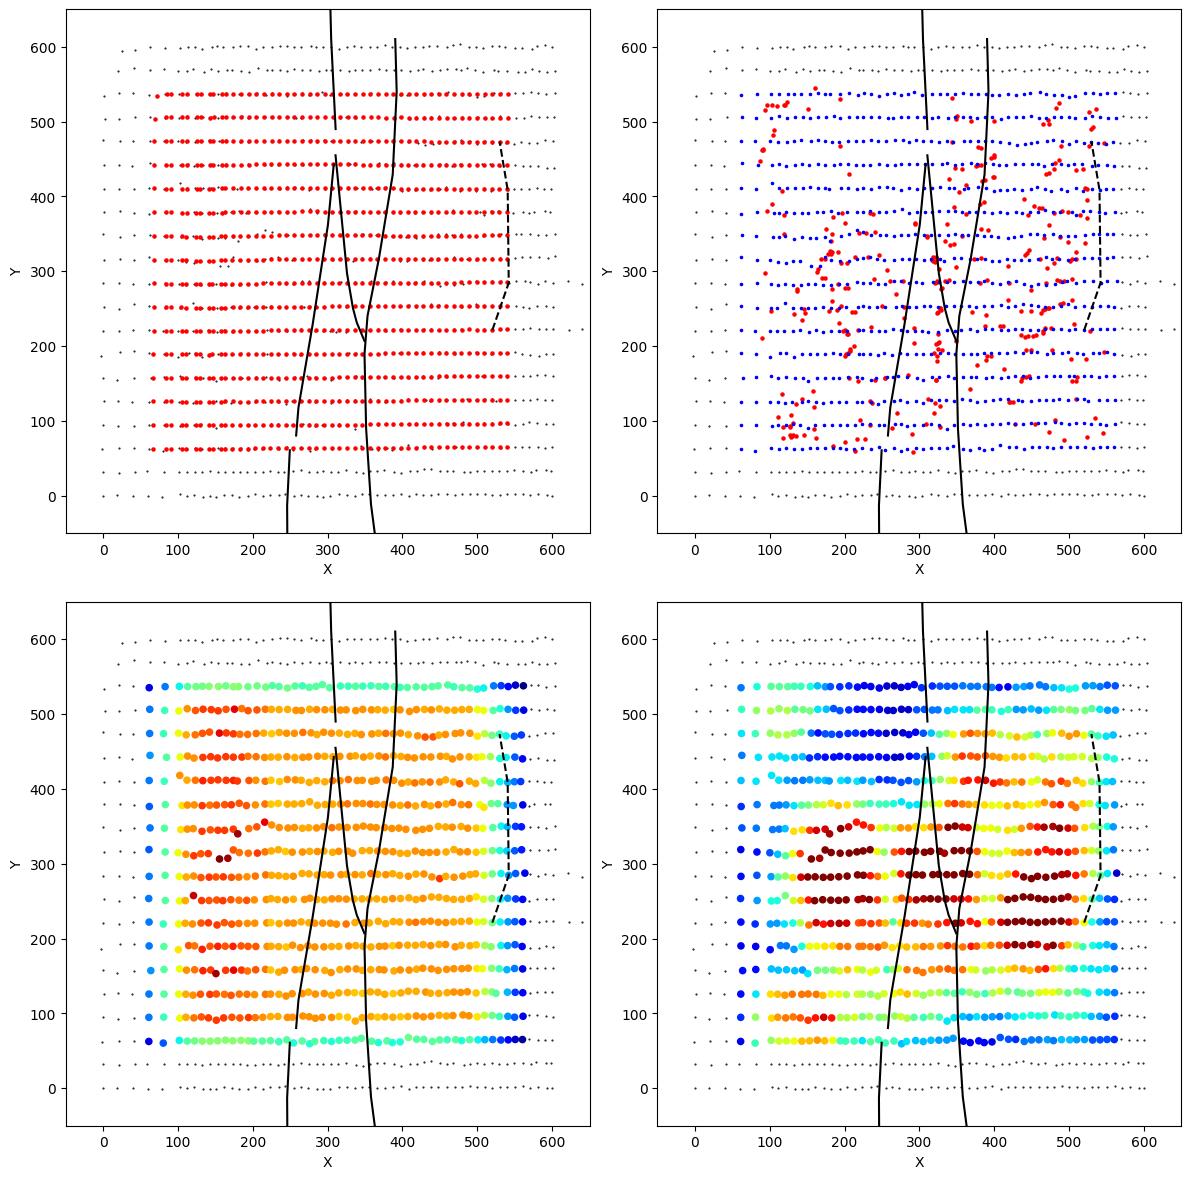

In [163]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.scatter(x_stations_all, y_stations_all,marker='.',color='k',s=1)
ax.scatter(x_centroid_targets,y_centroid_targets,c='r',marker='.',s=20)
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.plot(x_fault_infer, y_fault_infer, 'k--')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
ax.set_aspect('equal')
#ax.axis('off')
    
ax = fig.add_subplot(222)
ax.scatter(x_stations_all, y_stations_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.plot(x_fault_infer, y_fault_infer, 'k--')
ax.scatter(x_centroid_partition,y_centroid_partition,c='r',marker='.',s=20)
ax.scatter(x_stations_in, y_stations_in,marker='.',color='b',s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
ax.set_aspect('equal')

ax = fig.add_subplot(223)
ax.scatter(x_stations_all, y_stations_all,marker='.',color='k',s=1)
#ax.scatter(x_centroid_targets,y_centroid_targets,c='r',marker='.',s=20)
ax.scatter(x_stations_in, y_stations_in,c=flag_targets,s=20, cmap = 'jet',marker='o')
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.plot(x_fault_infer, y_fault_infer, 'k--')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
ax.set_aspect('equal')
#ax.axis('off')
    
ax = fig.add_subplot(224)
ax.scatter(x_stations_all, y_stations_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.plot(x_fault_infer, y_fault_infer, 'k--')
#ax.scatter(x_centroid_partition,y_centroid_partition,c='r',marker='.',s=20)
ax.scatter(x_stations_in, y_stations_in,c=flag_partitions,s=20, cmap = 'jet',marker='o',vmin=0,vmax=0.8)
#ax.scatter(x_stations_in, y_stations_in,marker='.',color='b',s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
ax.set_aspect('equal')

plt.tight_layout()
#plt.savefig(dir_image + 'station_distribution.png')